In [6]:
"""Some plots of the covid-19 data.

Setup:
* Check out the hopkins covid cases data: 

    git clone https://github.com/CSSEGISandData/COVID-19.git

* Download state populations:

    curl https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv > state_populations.csv
    
* Download global populations:

    curl https://datahub.io/JohnSnowLabs/population-figures-by-country/r/population-figures-by-country-csv.csv > country_populations.csv

* If you want to export images, install orca, which will run as a background server the first time you export:

    npm install -g electron@1.8.4 orca
     
* Install the requirements, in a virtualenv obviously. (Currently lazy `pip freeze`):

    pip install -r requiements.txt
     
"""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn as sns
import datetime as dt
import os

## Wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# DATA OPTIONS
START_DAY = dt.datetime(year=2020, month=2, day=16)
END_DAY = dt.datetime.utcnow() + dt.timedelta(days=1)

# EXPORT
# Export requires orca, see https://plot.ly/python/static-image-export/
EXPORT = True

pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 40)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [12]:
## LOAD THE DATA
# ... and clean it up

# Read data from https://github.com/CSSEGISandData/COVID-19/
conf = pd.read_csv(
    "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv",
    infer_datetime_format=True,
)
conf = conf.rename(
    columns={
        "Province/State": "state",
        "Country/Region": "country",
        "Lat": "lat",
        "Lon": "lon",
        "Cases": "cases",
        "Date": "date",
    }
)

# Normalize
conf = pd.melt(
    conf,
    id_vars=list(conf.columns[:4]),
    value_vars=list(conf.columns[4:]),
    var_name="date",
    value_name="cases",
)
conf["date"] = pd.to_datetime(conf["date"])

# Index by date
conf = conf.set_index("date")
conf


# Filter date ranges we care about
conf["day"] = (conf.index - START_DAY).days
conf = conf[conf["day"] > 0].copy()


####### US DATA
us = conf[conf["country"] == "US"].copy()

# Load state populations
# source: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/
popsdf = pd.read_csv("state_populations.csv")
# next(popsdsf)
pops = {p["NAME"]: int(p["POPESTIMATE2019"]) for _, p in list(popsdf.iterrows())}


# Data until ~03-10 is split by county, which is hella annoying
# First, add the county totals to the state totals
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
for abbrev, state in states.items():
    us.loc[us["state"].str.contains(abbrev), ["state"]] = state

# Remove any lingering county labels
us = us[~us["state"].str.contains(",")]
# Remove princesses
us = us[~us["state"].str.contains("incess")]
# Groupy by state
us = us.groupby(["date", "day", "state", "country"]).sum()
us = us.reset_index().set_index("day")

us["cases_per_100k"] = us.apply(
    lambda c: float(c.cases) * 100000 / pops.get(c.state, 100000000), axis=1
)


####### GLOBAL DATA
# source: https://datahub.io/JohnSnowLabs/population-figures-by-country
globpops_df = pd.read_csv("country_populations.csv")
globpops = {p["Country"]: int(p["Year_2010"]) for _, p in list(globpops_df.iterrows())}
## Fix some important ones
hopkins_name_from_popcsv = {
    "Iran": "Iran, Islamic Rep.",
    "Korea, South": "Korea, Rep.",
    "US": "United States",
}
for hopkins_name, csv_name in hopkins_name_from_popcsv.items():
    globpops[hopkins_name] = globpops[csv_name]

glob = conf.copy()

glob = glob.groupby(["date", "day", "country"]).sum()
glob = glob.reset_index().set_index("day")
glob["cases_per_100k"] = glob.apply(
    lambda c: float(c.cases) * 100000 / globpops.get(c.country, 100000000), axis=1
)

In [13]:
### Compute number of new cases per day
def new_cases_per_day(df, key="state", val="cases"):
    """Compute a new_cases column, add it to the df, and return the result."""
    df = df.copy()
    df.sort_values([key, "date"], inplace=True)

    # for this example, with diff, I think this syntax is a bit clunky
    # but for more general examples, this should be good.  But can we do better?
    df["new_cases"] = df.groupby([key])["cases"].transform(lambda x: x.diff())

    df.sort_index(inplace=True)
    return df


### Find the scary states/countries we want to plot
scary_state_counts = us.groupby(["state"])["cases_per_100k"].max()
scary_states = list(scary_state_counts[scary_state_counts > 1.0].copy().index)
scary_states = [c for c in scary_states if pops[c] > 6000000]
scary_cases = us[us["state"].isin(scary_states)].copy()
scary_cases = new_cases_per_day(scary_cases)

scary_country_counts = glob.groupby(["country"])["cases_per_100k"].max()
scary_countries = list(scary_country_counts[scary_country_counts > 1.5].copy().index)
# Filter out smaller countries
scary_countries = [c for c in scary_countries if globpops[c] > 20000000]

scary_country_cases = glob[glob["country"].isin(scary_countries)].copy()
scary_country_cases = new_cases_per_day(scary_country_cases, key="country")

In [14]:
## Try plotly?
import plotly.graph_objects as go
import plotly.express as px


def covidly(df, y="cases_per_100k", color="state", **kwargs):
    fig = px.line(df.reset_index(), x="date", y=y, color=color, height=800, **kwargs)
    return fig


def covidly_overlay(df, y="cases", color="state", **kwargs):
    line_fig = px.line(df.reset_index(), x="date", y=y, color=color, **kwargs)
    # Overlay bars. NOTE: this doesn't work well with more than ~5 plots
    bars_fig = px.bar(df.reset_index(), x="date", y="new_cases", color=color, height=800, **kwargs)
    for bar in bars_fig.data:
        line_fig.add_trace(bar)
    return line_fig


def covidly_bars(df, y="new_cases", color="state", **kwargs):
    bars_fig = px.bar(df.reset_index(), x="date", y=y, color=color, **kwargs)
    return bars_fig


if EXPORT and not os.path.exists("plots"):
    os.mkdir("plots")

pretty_date = dt.datetime.utcnow().strftime("%Y-%d-%m")

state_cases = covidly(scary_cases, y="cases_per_100k", log_y=True)
if EXPORT:
    state_cases.write_image(f"plots/us_cases_per_100k_lines_{pretty_date}.png")
state_cases.show()

state_cases_lbars = covidly_overlay(scary_cases, y="cases")
if EXPORT:
    state_cases_lbars.write_image(f"plots/us_cases_lines_bars_{pretty_date}.png")
state_cases_lbars.show()


state_cases_bars = covidly_bars(scary_cases, height=300)
if EXPORT:
    state_cases_bars.write_image(f"plots/us_cases_bars_{pretty_date}.png")
state_cases_bars.show()


world = covidly(scary_country_cases, y="cases", color="country", log_y=True)
if EXPORT:
    world.write_image(f"plots/world_cases_lines_{pretty_date}.png")
world.show()

world_per = covidly(
    scary_country_cases, y="cases_per_100k", color="country", log_y=True
)
if EXPORT:
    world_per.write_image(f"plots/world_cases_per_100k_lines_{pretty_date}.png")
world_per.show()

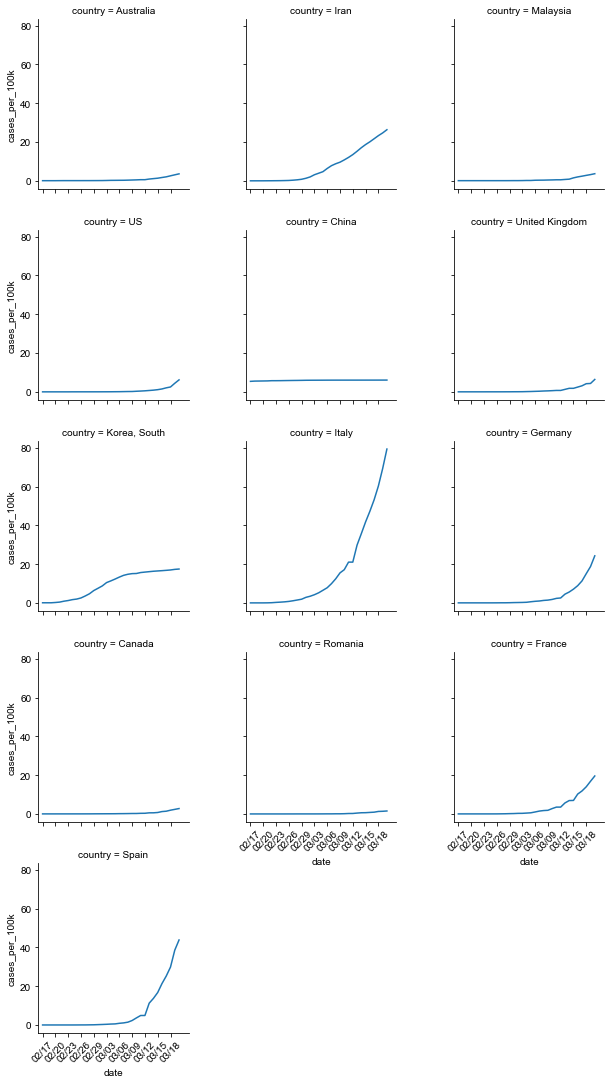

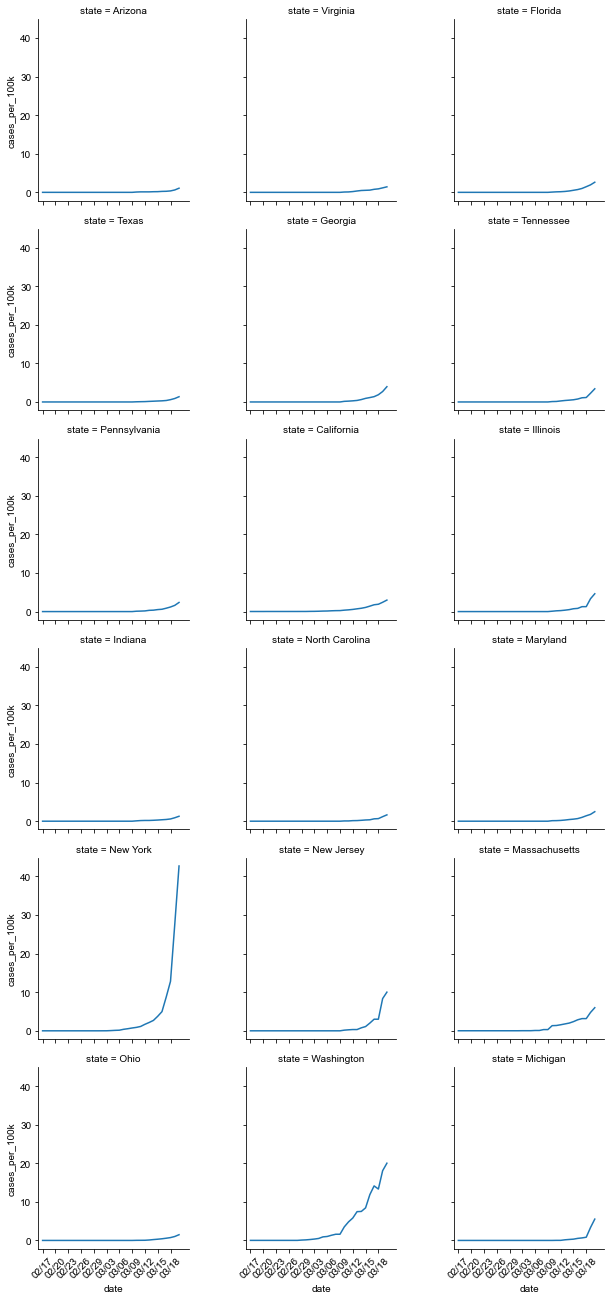

In [5]:
#### v1 plots, with seaborn.

import matplotlib.dates as mdates

date_fmt = mdates.DateFormatter("%m/%d")


def plovid(data, split="state"):
    sns.reset_orig()
    ax = sns.relplot(
        data=data.reset_index(),
        x="date",
        y="cases_per_100k",
        col=split,
        col_wrap=3,
        kind="line",
        ci=None,
        height=3,
    )
    ax.set(xlim=(START_DAY, END_DAY))
    xticks = np.array(data["date"].unique())[::3]
    ax.set(xticks=xticks)
    xlabels = [pd.to_datetime(str(i)).strftime("%m/%d") for i in xticks]
    ax.set_xticklabels(labels=xlabels, rotation=45)
    sns.set_style("ticks", {"xtick.major.formatter": date_fmt})
    return ax


ax = plovid(scary_country_cases, split="country")
ax.savefig("countries.png")
ax = plovid(scary_cases)
ax.savefig("us.png")